In [2]:
#load stuff
# using SPN
using Distributions
using Gadfly
#using Base.Test
using Lora
using Images, ImageView
#using ConjugatePriors


In [131]:
# config

n_features = 2
n_centers = 2
n_samples = 100

100

In [132]:
# make random data
centers = @parallel (hcat) for i = 1:n_features
    rand(Uniform(-10, 10), n_centers)
end

cluster_std = @parallel (hcat) for i = 1:n_features
  rand(Uniform(0.5, 4), n_centers)
end

n_samples_per_center = ones(Integer, n_centers) * int(n_samples / n_centers)

for i = 1:(n_centers % n_samples)
    n_samples_per_center[i] += 1
end

X = @parallel (hcat) for i = 1:n_centers
  rand(MvNormal(ones(n_features) .* centers[i], eye(n_features) .* cluster_std[i]), n_samples_per_center[i])
end

X = X';

In [133]:
Y = @parallel (vcat) for i = 1:n_centers
  y = ones(n_samples_per_center[i]) * i
end

ids = [1:size(X)[1]]
shuffle!(ids)

X = X[ids,:]
Y = Y[ids];

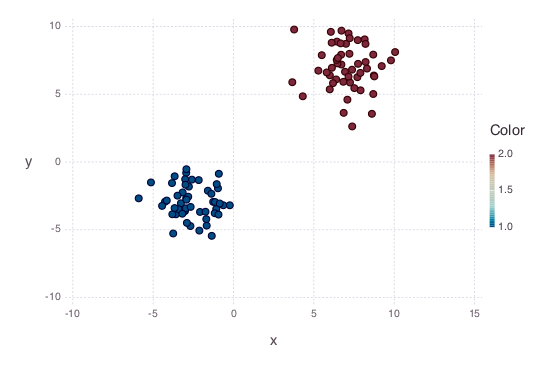

In [134]:
# plot data
plot(x = X[:,1], y = X[:,2], color = Y)

In [6]:
# put inverse Gamma prior on alpha (concentration) parameter. 
# see: Ramussen (2000), Eq. 15

function condpost_alpha (alpha, N, k)
    a = alpha^(k-3/2) * exp(-1 ./ (2*alpha)) * gamma(alpha)
    b = gamma(N + alpha)
    
    return a / b
end

condpost_alpha (generic function with 1 method)

In [7]:
function logcondpost_alpha (alpha, N, k)
    a = log(alpha)*(k-3/2) -1 ./ (2*alpha) + lgamma(alpha)
    b = lgamma(N + alpha)
    
    return a - b
end

logcondpost_alpha (generic function with 1 method)

In [28]:
# sampling of alpha using slice samples

alpha = 2.0
N = 100
K = 2

function slice_sample_alpha(alpha::Float64, n::Int, k::Int)

    function logcondpost_alpha(alpha::Float64)
        if alpha <= 0
            alpha = 0.0000001
        end
        h(X) = (k-3/2)*log(X) - 1./(2*X) + lgamma(X) - lgamma(n+X)
        return h(alpha)
    end

    mcmodel = model(logcondpost_alpha, init=alpha)#[10, ones(1)])

    mcsampler = SliceSampler()
    mcrunner = SerialMC(nsteps=2, burnin=1)
    mcchain = run(mcmodel, mcsampler, mcrunner)

    samples01 = mcchain.samples[:,1]
    return samples01
end

println("new alpha: ", slice_sample_alpha(alpha, N, K))

#ess01 = ess(samples01, maxlag=1)

new alpha: [0.2072909080090053]


In [78]:
function sample_hyperparameter_alpha(alpha::Float64, gamma_a::Float64, gamma_b::Float64, N::Int, k::Int)
    # implementation according to escobar - west page 585
    # equations: 13 and 14.
    
    # 1) sample \eta ~ Beta(\alpha + 1, N)
    eta = rand(Beta(alpha + 1, N))
    
    # 2) sample c ~ Bernoulli(\pi)
    #pi = gamma_a + k - 1;
    #rate = 1.0/gamma_b - log(eta);
    #pi = pi / (pi + rate * N);
    
    pi = (gamma_a + k - 1)/(gamma_a + k + gamma_b*N - N*log(eta) - 1)
    
    c = rand(Bernoulli(pi))
    
    # 3) sample alpha from Gamma(a + k, b - log(\eta)) or from Gamma(a + k - 1, b - log(\eta))
    if c == 0
        return rand(Gamma(gamma_a + k, gamma_b - log(eta)))
    else
        return rand(Gamma(gamma_a + k - 1, gamma_b - log(eta)))
    end
    
    return pi * rand(Gamma(gamma_a + k, gamma_b - log(eta))) + (1-pi) * rand(Gamma(gamma_a + k - 1, gamma_b - log(eta)))
    
    return alpha
    
end

sample_hyperparameter_alpha (generic function with 1 method)

In [49]:
alpha = 1.0
gamma_a = 1.0
gamma_b = 1.0
n = 100
k = 1

simsamplesize = 20

n_alpha = 0

for s in 1:simsamplesize
    n_alpha += sample_hyperparameter_alpha(alpha, gamma_a, gamma_b, n, k)
end

n_alpha /= simsamplesize

7.375517934835851

In [29]:
# student-t distribution pdf
function logpdf_t(x::Array{Float64}, mu::Vector{Float64}, Sigma::Array{Float64}, nu::Float64)
    (N, d) = size(x)

    M = repmat(mu', N, 1)
    X = x-M;

    mahal = sum((X*inv(Sigma)).*X,2)[1]

    logc = lgamma(nu/2 + d/2) - lgamma(nu/2) - 0.5*logdet(Sigma) - (d/2)*log(nu) - (d/2)*log(pi);
    logp = logc -(nu+d)/2*log1p(mahal/nu);
end

logpdf_t (generic function with 1 method)

In [65]:
# test run logpdf_t
d = MvTDist(nu, mu, Sigma)

println(log(pdf(d, x)))
println("log p: ", logpdf_t(x', mu, Sigma, nu))

@time log(pdf(d, x))
@time logpdf_t(x', mu, Sigma, nu)

-3.224171427529236
log p: -3.224171427529236
elapsed time: 4.8429e-5 seconds (400 bytes allocated)
elapsed time: 0.000125789 seconds (7256 bytes allocated)


-3.224171427529236

In [53]:
# compute log likelihood for data assignment. 
# For the case of a conjugate prior, and using Gaussian distribution with 
# Normal Inverse-Wishart as prior this reduces to a multivariate student-t distribution.
# see: http://www.cs.cmu.edu/~rajarshd/talks/DPGMM_tutorial.pdf, page 6

# According to http://cs.brown.edu/~sudderth/papers/sudderthPhD.pdf, page 47
# this can be approcimated by a moment-moving Gaussian. (if v > 0)

function predict_student(z::Array{Float64}, kappa0::Float64, nu0::Float64, mu0::Vector{Float64}, Lambda0::Array{Float64})
    p = length(mu0);

    nu = nu0-p+1;
    S = Lambda0*(kappa0+1)/kappa0/(nu);

    a = (z-mu0)'*inv(S)*(z-mu0)
    b = -(nu+p)/2
    c = (1+a[1]/nu)^b*gamma((nu+p)/2)/gamma((nu)/2)
    
    return c*(det(nu*p*S))^-.5
end

predict_student (generic function with 1 method)

In [54]:
# parameters..

# count of pseudo-observations
kappa = 1.0

1.0

In [57]:
# test

# println("llh: ", log(predict_student(x, kappa, nu, mu, Sigma)))
# println("llh: ", logpdf_t(vec(X[2,:])', mu, S, nu))

x = [1.0, 1.0]
mu = [0.0, 0.0]
Sigma = eye(2)
nu = 2.0

println(log(predict_student(x, kappa, nu, mu, Sigma)))
println(llh_student(vec(x), vec([0.0 0.0]), 0.0, 0, D, kappa, nu, mu, Sigma))
#@time logpdf_t(x, mu, Sigma, nu)


(T, U) = meshgrid([-10:10], [-10:10])
U = (reshape(U, prod(size(U))))
T = (reshape(T, prod(size(T))))


P = zeros(length(U))

s = mu
ss = 0

kappa0 = kappa
nu0 = nu
mu0 = mu
lambda0 = Sigma

XI = zeros(10, D)

for i = 1:10
    
    xi = x + randn(D)
    XI[i,:] = xi

    s += xi
    ss += dot(xi, xi)

    kappa1 = kappa0 + 1
    nu1 = nu0 + 1
    mu1 = kappa0 / (kappa0 + 1) * mu0+1 /(kappa0+1)*xi
    lambda1 = lambda0+kappa0/(kappa0 + 1)*dot((xi-mu0), (xi-mu0))
    
    kappa0 = kappa1
    nu0 = nu1
    mu0 = mu1
    lambda0 = lambda1
end

for i = 1:length(U)
    
    P[i] = predict_student(vec([float(U[i]) float(T[i])]), kappa0, nu0, mu0, lambda0)
    #P[i] = exp(llh_student(vec([float(U[i]) float(T[i])]), s, ss, 10, D, kappa, nu, mu, Sigma))
end

plot(x = U, y = T, color = P, Scale.x_continuous(minvalue=-10, maxvalue=10))
plot(x = XI[:,1], y = XI[:,2], Scale.x_continuous(minvalue=-10, maxvalue=10), Scale.y_continuous(minvalue=-10, maxvalue=10))


-3.119162312519754


LoadError: `llh_student` has no method matching llh_student(::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Int64, ::Float64, ::Float64, ::Array{Float64,1}, ::Array{Float64,2})
while loading In[57], in expression starting on line 12

In [119]:
sums = vec([0.0, 0.0])
ssums = 0

data = [1.0 1.0;
        1.1 1.1;
        1.0 1.1;
        1.1 1.0]

(N, D) = size(data)

Z = [1 1 1 1]

clusters = unique(Z)
counts = zeros(Int, length(clusters))
sums = zeros(length(clusters), D)
ssums = zeros(length(clusters))

# compute sufficient statistics:
# sums: sum_i x_i
# ssums: sum_i x_i' * x_i

for (index, item) in enumerate(Z)

    counts[item] += 1
    sums[item, :] += vec(data[index,:])'
    ssums[item] += dot(vec(data[index,:]), vec(data[index,:]))
end

println("counts: ", counts)
println("sums: ", sums)
println("ssums: ", ssums)

# set parameters for first assignments
n = counts[1]
mu = vec(sums[1,:]/n)
dotsum = ssums[1]

println("n: ", n)
println("mu: ", mu)
println("dotsum: ", dotsum)

# parameter for G0
nu_0 = 1.0
kappa_0 = 0.0
mu_0 = zeros(D)
sigma_0 = eye(D) * 1

println("nu_0: ", nu_0)
println("kappa_0: ", kappa_0)
println("mu_0: ", mu_0)
println("sigma_0: ", sigma_0)

# calculate NIW parameters
mu_n = (kappa_0 * mu_0 + n * mu) / (kappa_0 + n)
println("mu_n: ", mu_n)

kappa_n = kappa_0 + n
println("kappa_n: ", kappa_n)

nu_n = nu_0 + n
println("nu_n: ", nu_n)

sigma_n = (sigma_0 + dotsum + (kappa_0 * n) / (kappa_0 + n)) * dot(mu - mu_0, mu - mu_0)
println("sigma_n: ", sigma_n)

# calculate llh
psi = (sigma_n * (kappa_n + 1)) / (kappa_n * (nu_n - D + 1))

df = float(nu_n - D + 1)

x = vec([1.0 1.0])

llh = (1+(x-mu_n)'*psi^-1*(x-mu_n)/df).^(-(df+D)/2.0)*exp(lgamma((df+D)/2))/exp(lgamma((df)/2))*(det(df*D*psi))^-.5;

# llh = logpdf_t([1.0 1.0], vec(mu_n), psi, df)
println("P: ", llh)

# check result
max = 0
best = [0.0 0.0]
LLH = zeros(41, 41)

ii = 1
jj = 1

for i = -10.0:0.5:10.0
    for j = -10.0:0.5:10.0
        x = vec([i j])
        llh = (1+(x-mu_n)'*psi^-1*(x-mu_n)/df).^(-(df+D)/2.0)*exp(lgamma((df+D)/2))/exp(lgamma((df)/2))*(det(df*D*psi))^-.5
        llh = llh[1]
        if llh > max
            max = llh
            best = [i j]
        end
        
        LLH[ii, jj] = llh
        
        jj+=1
    end
    jj = 1
    ii+=1
end

println(max)
println(best)


using ImageView

I = grayim(LLH .* 255)

ImageView.view(I)

counts: [4]
sums: [4.2 4.2]
ssums: [8.84]
n: 4
mu: [1.05,1.05]
dotsum: 8.84
nu_0: 1.0
kappa_0: 0.0
mu_0: [0.0,0.0]
sigma_0: [1.0 0.0
 0.0 1.0]
mu_n: [1.05,1.05]
kappa_n: 4.0
nu_n: 5.0
sigma_n: [21.6972 19.4922
 19.4922 21.6972]
P: [0.08392018591107274]
0.08392018591107274
[1.0 1.0]


(ImageCanvas,ImageSlice2d: zoom = BoundingBox(0.0,41.0,0.0,41.0))

In [22]:
function collapsedGibbsMvNormal(x::Array{Float64}, sums::Array{Float64}, 
    ssum::Array{Float64}, n::Float64, D::Float64, kappa_0::Float64, nu_0::Float64, mu_0::Array{Float64}, sigma_0::Array{Float64})
    
    if n > 0
        mu = sums / n
        mu_n = ((kappa_0 * mu_0) + (n * mu)) / (kappa_0 + n)
        kappa_n = kappa_0 + n
        nu_n = nu_0 + n
        C = ssum - n * (mu * mu')
        # println("C: ", C)
        #sigma_n = sigma_0 + C + ( (mu - mu_0) * (mu - mu_0)' ) * (kappa_0 * n / kappa_n)
        sigma_n = sigma_0 + ssum - (kappa_0 + n) * (mu_n * mu_n') + ( kappa_0 * (mu_0 * mu_0') )
        
        
    else
        mu = mu_0
        mu_n = mu_0
        kappa_n = kappa_0
        nu_n = nu_0
        sigma_n = sigma_0
    end
    
    #println("mu_n: ", mu_n)
    #println("kappa_n: ", kappa_n)
    #println("nu_n: ", nu_n)
    
    # println("sigma_n: ", sigma_n)

    mean = mu_n
    covar = sigma_n * ((kappa_n + 1) / (kappa_n * (nu_n - D + 1)))
    
    #println("x: ", x)
    #println("mean:", mean)
    #println("cov:", covar)
    #println(nu - D + 1)
    
    # hard coded
    #x_mu = x - mean
    #cdet = det(covar)
    #cinv = inv(covar)
    
    #norm = 1.0/( (2*pi)^(D/2.0) * cdet^0.5 )
    #logPdf = -0.5 * dot(cinv * x_mu, x_mu) + log(norm);
    #return logPdf
    
    d = MvTDist(nu - D + 1, mean, covar)

    return(pdf(d, x))    
    #return (1+(x-mu_n)'*covar^-1*(x-mu_n)/df).^(-(df+D)/2.0)*exp(lgamma((df+D)/2))/exp(lgamma((df)/2))*(det(df*D*covar))^-.5;
end

collapsedGibbsMvNormal (generic function with 1 method)

In [21]:
# compute chinese restaurant priors
function crp_prior(counts::Array{Int}, N::Int, alpha::Float64)
    #@parallel (vcat) for x in counts
    #    float(x) / (N + alpha - 1)
    #end
    [float(x) / (N + alpha - 1) for x in counts]
end

crp_prior (generic function with 1 method)

## collapsed Gibbs sampler

In [24]:
# unit test with test data
X = [-6.701894283260378 -5.080725463712779;
 -5.085696089229253 -4.3540703923932496;
 -6.2735501731783465 -4.407291073069036;
 -5.483682678071926 -6.613574324101342;
 6.201076401386997 6.888668208238243;
 -4.911528487899628 -5.150925207334576;
 7.156277934568658 8.826938674236363;
 8.483521288874254 4.937732876921746;
 7.893765277279374 4.493672922613312;
 -4.539029298812412 -6.240260297810027;
 7.078906421986907 8.038978987563972;
 -6.1372215756436885 -6.605844513285994;
 7.940842104624188 9.162830908124858;
 -4.811553181288863 -6.201052513514664;
 9.089003499067582 8.688063087425421;
 -4.505331928172086 -5.076947794578476;
 -5.671134838391116 -6.066036771640539;
 -6.456882257745111 -6.434626012729744;
 8.258236521508003 8.30613688101434;
 -5.6471711468633865 -4.607508236504746;
 7.62841707115238 7.812861577812666;
 7.835292554348588 8.131662880975963;
 -7.440024325741035 -5.742762361442205;
 -7.102598383036417 -6.673887372590816;
 10.027672546858003 7.161009345606931;
 -5.932405919235541 -5.2674136625133965;
 -6.417548349198135 -6.844308029989431;
 7.886104580662259 7.170244271050994;
 7.431329327140468 7.981677144099394;
 6.09697623735461 7.5558851786891745;
 -5.08656985707465 -6.866447675890739;
 9.808403522435249 8.86476158317241;
 -5.7761227976112695 -5.520835914096299;
 8.014528890945085 7.22576489976722;
 -4.962738067252818 -6.013939197379913;
 6.885920940533097 6.242552004745092;
 6.847521315339099 9.383897169135434;
 -5.459848404521173 -6.3199293577864;
 7.21717603067646 8.343819031435599;
 7.471784847307465 6.430733320063041;
 9.119798324168734 6.450993653654798;
 7.8855170344548 7.801610805281444;
 -6.421102508984193 -7.390923986815585;
 8.456926279097079 8.349803751834445;
 9.016288734802526 8.216491919240298;
 9.34267380280983 6.396005331579526;
 9.233964456621592 5.842900034270691;
 7.4490979314536245 5.466637268425819;
 7.629709466914268 8.909718949030987;
 5.528654632108777 10.169164940062213;
 -5.536888018085841 -6.431889929591723;
 9.149414352946879 5.802874599993201;
 -5.833579135182066 -5.047346145907177;
 -6.542041810667056 -4.999742117129269;
 -4.778338584347505 -6.401424649019862;
 -4.92547587160342 -4.927738713884947;
 7.078989099622791 8.509820319844977;
 -4.968126188555106 -5.524856030914197;
 8.185200258400092 5.877482752261246;
 7.520252139525395 7.308070941515766;
 -6.601308956080349 -5.5529024686525625;
 -5.46433822222851 -5.832323934950004;
 7.477976485737906 7.511373738868853;
 7.62461386634402 6.950454544387667;
 6.672114943432506 7.223446842801055;
 8.624234436240876 8.742927033973688;
 -6.201498506041783 -5.567007017687195;
 -4.970415102724056 -3.7496132157638495;
 -5.286802090059721 -5.5610154574849195;
 5.595393284418524 7.094695417101431;
 -6.651682070171307 -6.19456646233661;
 -4.772453691093068 -6.040164918952838;
 -4.992452585548064 -6.488878278600482;
 -5.621888685235321 -5.252802156947712;
 7.319031049086095 8.9348828983735;
 -5.347326702747251 -6.951911667999898;
 -4.804255582425755 -5.769024340675484;
 -4.847698823965425 -5.611088105833474;
 9.145740398014668 8.786890199044375;
 6.144850464952093 9.311817928855103;
 -6.645708545819748 -6.394873054921878;
 6.329406234979944 7.900358940654054;
 7.692201900394217 9.725875587059573;
 -5.173428484340251 -5.425182455000502;
 -5.982487990353925 -6.141004274498348;
 -6.244554308672376 -5.518323652701396;
 7.3240659345152315 9.488502494340299;
 8.010913251122266 8.962048809930387;
 -5.548661793711776 -6.368284253564931;
 -4.819440801853763 -6.239124390090739;
 8.380148310218791 5.930576409015565;
 8.182645514373311 8.664560531097925;
 6.952053510334458 7.632077855032118;
 8.058495930880575 6.697967459761667;
 -6.613952225640064 -6.027988093256471;
 -4.594801039664905 -4.462113242941999;
 -5.879271924280067 -4.264493762383416;
 -5.8327850255541245 -5.342657940937584;
 5.573378643563577 8.126225417477476;
 9.487570700490947 5.53004777711277;
 -6.1511966693657705 -5.819858010035073;
 -5.097210691044011 -5.434679774426001];

In [173]:
(N, D) = size(X)

# init sum and ssum
# use k-means for initialization
using Clustering

R = kmeans(X', 2; maxiter=10)

Z = assignments(R) # k-means
#Z = ones(Int, N) # all one
Z = rand(1:5, N) # random

# Dirichlet concentration parameter
alpha = N / 50

# parameter for G0
nu = 4.0
kappa = 1.0
mu = mean(X, 1)
Sigma = eye(D) * 100

println("mu: ", mu)
println("sigma: ", Sigma)

clusters = unique(Z)
counts = zeros(Int, length(clusters))
sums = zeros(D, length(clusters))
ssums = zeros(D, D, length(clusters))

# compute sufficient statistics:
# sums: sum_i x_i
# ssums: sum_i x_i' * x_i

println("computing sufficient stats")

println(vec([1 1]) * vec([1 2])')

for (index, item) in enumerate(Z)
    
    x = vec(X[index,:])
    
    counts[item] += 1
    sums[:, item] += x
    ssums[:, :, item] += x * x'
end

println("sums: ", sums)
println("ssums: ", ssums)

for c in unique(Z)
    println("sums (c): ", sums[:,c])
    mu = vec(sums[:,c] / counts[c])
    println("mu (c): ", mu)
    println("cov (c):", (ssums[:,:,c] - counts[c] * (mu * mu')) )
end

mu: [2.2481720672579777 2.0365151004241384]
sigma: [100.0 0.0
 0.0 100.0]
computing sufficient stats
[1 2
 1 2]
sums: [49.5922673410592 36.44439090164993 37.77970284718103 68.84360722733769 36.65358254308586
 42.54787269027576 42.343904639043195 29.630922671963297 71.7118967140665 21.489943527913365]
ssums: [659.7175688050587 591.4964580635343
 591.4964580635343 627.2531741161749]

[726.153273460297 728.5154550937142
 728.5154550937142 806.9929188830916]

[483.7420761459317 467.1206423368928
 467.1206423368928 529.791557941357]

[732.4182643223874 753.0704808376162
 753.0704808376162 850.198654060165]

[464.5675850155686 363.06637745797445
 363.06637745797445 330.96279034297817]
sums (c): [37.77970284718103,29.630922671963297]
mu (c): [1.9884054130095279,1.559522245892805]
cov (c):[408.6207105027055 408.20235530349424
 408.20235530349424 483.5814748681008]
sums (c): [68.84360722733769,71.7118967140665]
mu (c): [3.1292548739698947,3.2596316688212044]
cov (c):[516.9890708645719 528.66567

In [58]:
function plot2DGaussian(dists::Array{MvNormal}; clim::(Float64, Float64, Float64, Float64) = (-10.0, 10.0, -10.0, 10.0), res::Int=50)
    
    sx = (clim[2]-clim[1])/(res-1)
    sy = (clim[4]-clim[3])/(res-1)
    A = Array(Float64,2,res^2)
    for (i,a) in enumerate(clim[1]:sx:clim[2])
        for (j,b) in enumerate(clim[3]:sy:clim[4])
            A[:,(i-1)*res+j] = [a,b]
        end
    end

    p = zeros(res * res)
    for d in dists
        p += pdf(d, A)
    end
    # mu = predict(gp,A)[1]
    z= reshape(p,res,res)
    return Gadfly.plot(z=z,x=[clim[1]:sx:clim[2]],y=[clim[3]:sy:clim[4]],Gadfly.Geom.contour)
end

plot2DGaussian (generic function with 1 method)

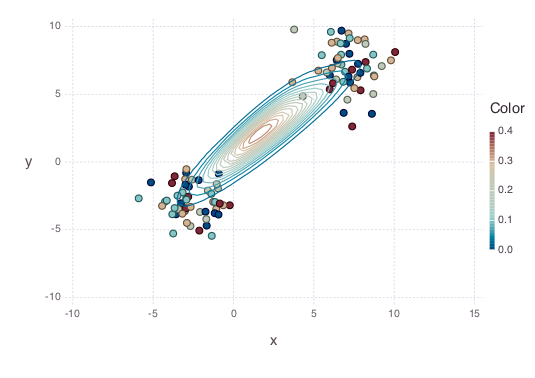

In [174]:
# plot distributions

dists = Array(MvNormal, length( unique( Z ) ) )

for c in unique(Z)
    mu = vec(sums[:,c] / counts[c])
    S = (ssums[:,:,c] - counts[c] * (mu * mu')) / (N - 1)
    
    dists[c] = MvNormal(mu, S)
end

p1 = plot2DGaussian(dists)
p2 = plot(x = X[:,1], y = X[:,2], color = Z, Geom.point)

append!(p1.layers, layer(x = X[:,1], y = X[:,2], color = Z, Geom.point))

vstack(p1)

In [ ]:
function sample_cluster_assignment(X::Array{Float64}, Z::Array{Int}, 
    sums::Array{Float64}, ssums::Array{Float64},
    counts::Array{Int}, N::Int, D::Int,
    kappa::Float64, nu::Float64, mu::Array{Float64}, Sigma::Array{Float64},
    alpha::Float64)
    
    for item = 1:size(X)[1]

        # remove assignment
        c = Z[item]
        x = vec(X[item, :])

        if counts[c] < 2
            counts = counts[[1:c-1, c+1:end]]
            sums = sums[:, [1:c-1, c+1:end]]
            ssums = ssums[:, :, [1:c-1, c+1:end]]
            
            # move index‚
            Z[Z .> c] -= 1
            Z[item] = 0
        else
            counts[c] -= 1
            sums[:,c] -= x
            ssums[:,:,c] -= x*x'
            Z[item] = 0
        end 

        clusters = unique(Z)
        deleteat!(clusters, find(clusters .== 0))

        old_K = length(clusters)

        # TODO: it migth be better to use the log
        # calculate posterior predictive
        p = zeros(old_K)
        for i in clusters
            likelihood = collapsedGibbsMvNormal(x, vec(sums[:,i]), ssums[:,:,i], float(counts[i]), float(D), kappa, nu, vec(mu), Sigma)
            prior = float(counts[i]) / (N + alpha - 1) 
            
            p[i] = likelihood * prior
        end
        
        # prob new cluster
        G0 = collapsedGibbsMvNormal(x, zeros(D), zeros(D, D), 0.0, float(D), kappa, nu, vec(mu), Sigma)[1]
        prior0 = alpha / (N + alpha - 1)
        
        p = vcat(p, G0 * prior0)
        prob = p / sum(p)
        
        cdf = cumsum(prob)
        
        # find best cluster
        rd = rand()
        k = sum(cdf .< rd) + 1

        Z[item] = k

        if k > old_K
            # new cluster
            counts = cat(1, counts, 1)
            sums = cat(2, sums, x)
            ssums = cat(3, ssums, x*x' )
        else

            counts[k] += 1
            sums[:,k] += x
            ssums[:,:,k] += x*x'
        end
        
    end
    
    return (Z, sums, ssums, counts)
    
end

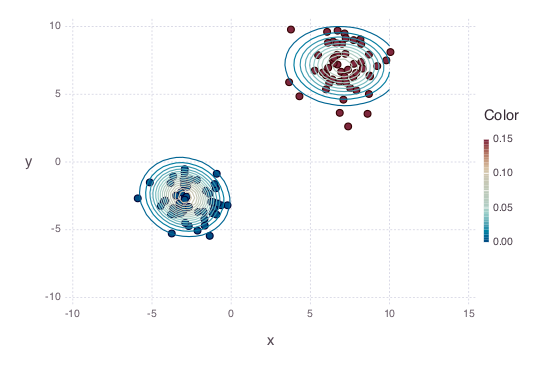

In [183]:
# run collabsed gibbs iterations

simsamplesize = 10
max_iter = 100
LLH = zeros(max_iter)
Clusters = zeros(max_iter)

for iter = 1:max_iter

    # one Gibbs iteration
    
    # --
    # sample cluster assignments
    (Z, sums, ssums, counts) = sample_cluster_assignment(X, Z, 
                                    sums, ssums,
                                    counts, N, D,
                                    kappa, nu, mu, Sigma,
                                    alpha)
    
    # get new number of clusters
    K = length(unique(Z))
    
    # --
    # sample new alpha
    n_alpha = 0

    for s in 1:simsamplesize
        #n_alpha += sample_hyperparameter_alpha(alpha, 1.0, 1.0, N, K)
        n_alpha += slice_sample_alpha(alpha, N, K)[1]
    end

    alpha = n_alpha / simsamplesize
    #alpha /= 1
    
    # -- 
    # compute llh of model
    dists = Array(MvNormal, length( unique( Z ) ) )

    for c in unique(Z)
        mu = vec(sums[:,c] / counts[c])
        S = (ssums[:,:,c] - counts[c] * (mu * mu')) / (N - 1)

        S += eye(D)

        dists[c] = MvNormal(mu, S)
    end

    llh = map(c -> logpdf(dists[c], X'), unique(Z))
    llh = reduce(hcat, llh)

    # --
    # store values for plotting
    LLH[iter] = mean(maximum(llh, 2))
    Clusters[iter] = K
        
end

# plot data
dists = Array(MvNormal, length( unique( Z ) ) )

for c in unique(Z)
    mu = vec(sums[:,c] / counts[c])
    S = (ssums[:,:,c] - counts[c] * (mu * mu')) / (counts[c] - 1)
    
    if counts[c] == 1
        S = eye(D)
    end
    dists[c] = MvNormal(mu, S)
end

p1 = plot2DGaussian(dists)

append!(p1.layers, layer(x = X[:,1], y = X[:,2], color = Z, Geom.point))

vstack(p1)

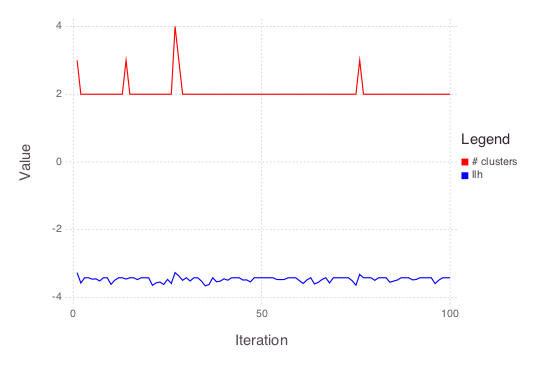

In [186]:
# plot data
plot(
            layer(x = 1:max_iter, y = Clusters,
            Geom.line,
            Theme(default_color=color("red"))),

            layer(x = 1:max_iter, y = LLH,
            Geom.line,
            Theme(default_color=color("blue"))),
            
            Guide.manual_color_key("Legend", 
            ["# clusters", "llh"], 
            [color("red"), color("blue")]),

            Guide.xlabel("Iteration"),
            Guide.ylabel("Value")
       )